In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)
import warnings; warnings.filterwarnings("ignore")

import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import sys; sys.path.append('../')
from PDE_FIND import *
import scipy.io as sio
import itertools

import numpy as np
import pandas as pde_diff_new
from mpl_toolkits.mplot3d import Axes3D
from sympy import symbols

import sys; sys.path.append('../')
from PDE_FIND import *
from solvel0 import solvel0, refine_solvel0

import sys; sys.path.append('../../parametric-discovery/')
from best_subset import *
from frols import frols
from p_linear_regression import PLinearRegression
from r_pca import R_pca
from pde_diff_new import RPCA

import scipy.io as sio
from scipy.signal import savgol_filter
import itertools

from sklearn.preprocessing import normalize
from sklearn.linear_model import Ridge, BayesianRidge, LinearRegression as SkLinearRegression
from sklearn.base import BaseEstimator
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from abess.linear import LinearRegression
import pysindy as ps

from tqdm import trange
from os.path import join as join_path
FIGURE_EXPORT_PATH = "/Users/pongpisit/Documents/figure_export/"

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
Sklearn's version: 1.2.2
mrmr is not installed in the env you are using. This may cause an error in future if you try to use the (missing) lib.


In [2]:
data = sio.loadmat("/Users/pongpisit/Desktop/research/examples/pde/datasets/gray_scott_2d_maxt10_V2.mat")
# data = sio.loadmat("../Datasets/reaction_diffusion_rudy.mat")

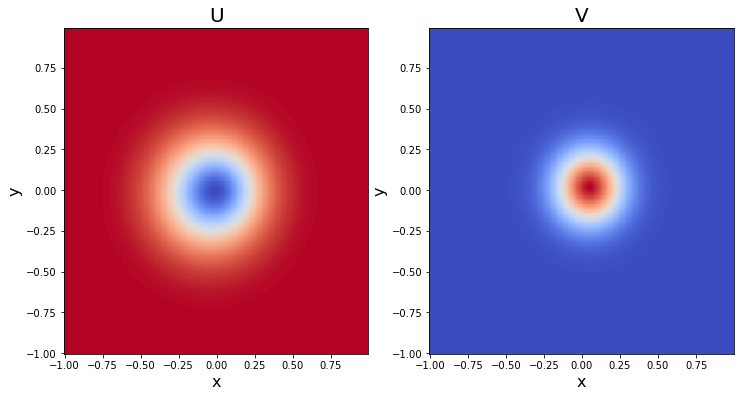

In [3]:
t = data['tspan'][0,:]
x = data['u_grid'][0,:]
y = data['v_grid'][0,:]
u_sol = data['usol']
v_sol = data['vsol']

dt = t[1] - t[0]
dx = x[1] - x[0]
dy = y[1] - y[0]

pylab.rcParams['figure.figsize'] = (12, 6)
figure()
xx, yy = meshgrid(x, y)
subplot(1,2,1)
pcolor(xx,yy,u_sol[:,:,10],cmap='coolwarm')
title('U', fontsize = 20)
xlabel('x', fontsize = 16)
ylabel('y', fontsize = 16)
subplot(1,2,2)
pcolor(xx,yy,v_sol[:,:,10],cmap='coolwarm')
title('V', fontsize = 20)
xlabel('x', fontsize = 16)
ylabel('y', fontsize = 16)
pylab.rcParams['figure.figsize'] = (12, 8)

In [4]:
u = np.zeros((x.shape[0], y.shape[0], len(t), 2))
u[:, :, :, 0] = u_sol
u[:, :, :, 1] = v_sol

# Odd polynomial terms in (u, v), up to second order derivatives in (u, v)
library_functions = [
    lambda x: x,
    lambda x: x * x * x,
    lambda x, y: x * y * y,
    lambda x, y: x * x * y,
]
library_function_names = [
    lambda x: x,
    lambda x: x + x + x,
    lambda x, y: x + y + y,
    lambda x, y: x + x + y,
]

# Need to define the 2D spatial grid before calling the library
np.random.seed(100)
X, Y, T = np.meshgrid(x, y, t, indexing='ij')
XYT = np.transpose([X, Y, T], [1, 2, 3, 0])

In [5]:
# Need to increase the weak form mesh resolution a bit if data is noisy
weak_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatiotemporal_grid=XYT,
    K=10000,
    is_uniform=True,
    periodic=False,
    include_interaction=True, 
    include_bias=True,
    cache=True
)

### Noiseless ###
u_noisy = u.copy()

### Add noise ###
noise_lv = 0 # 1e-1
domain_noise = 0.01*np.abs(noise_lv)*np.std(u_noisy)*np.random.randn(*u_noisy.shape)
u_noisy = u_noisy + domain_noise

In [6]:
# thres = 1e-4 # 1e-3
# # optimizer = ps.STLSQ(threshold=thres, fit_intercept=True, normalize_columns=True, max_iter=100)
# optimizer = ps.SR3(threshold=thres, normalize_columns=True, max_iter=100)
# # optimizer = ps.MIOSR(target_sparsity=2*7, fit_intercept=False, normalize_columns=True)

# model = ps.SINDy(feature_library=weak_lib, optimizer=optimizer, 
#                  cache=True, feature_names=['u', 'v'])
# model.fit(u_noisy, ensemble=False, library_ensemble=True)
# model.print()

# X_pre, y_pre = model.feature_library.cached_xp_full[0], model.cached_x_dot
# np.save("./IPI_output_files/X_pre_V2_clean.npy", X_pre)
# np.save("./IPI_output_files/y_pre_V2_clean.npy", y_pre)
# # np.save("./IPI_output_files/feature_names.npy", model.get_feature_names())

In [7]:
# X_pre = np.load("./IPI_output_files/X_pre_clean.npy")
# y_pre = np.load("./IPI_output_files/y_pre_clean.npy")

X_pre = np.load("./IPI_output_files/X_pre_V2_clean.npy")
y_pre = np.load("./IPI_output_files/y_pre_V2_clean.npy")

u_pre, v_pre = y_pre[:, 0:1], y_pre[:, 1:2]; del y_pre
feature_names = np.load("./IPI_output_files/feature_names.npy")

In [8]:
solve_grb = solvel0(X_pre, v_pre, intercept=False, refine=True, max_complexity=10)
# print(solve_grb)
solve_grb_normal = solvel0(X_pre, v_pre, is_normal=True, intercept=False, refine=True, max_complexity=10)
# print(solve_grb_normal)
solve_grb = refine_solvel0(solve_grb+solve_grb_normal, (X_pre, v_pre)); del solve_grb_normal
solve_grb = sorted([e[0] for e in solve_grb.track.values()], key=len)
solve_grb

  0%|                                                                            | 0/10 [00:00<?, ?it/s]

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-04


100%|███████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.47it/s]


Call backward_refinement...


100%|███████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.16s/it]


Call backward_refinement...


[(40,),
 (35, 71),
 (6, 35, 71),
 (2, 5, 10, 16),
 (2, 5, 10, 16, 72),
 (2, 5, 6, 10, 16, 72),
 (2, 5, 6, 10, 16, 53, 72),
 (2, 5, 6, 10, 16, 53, 72, 76),
 (2, 5, 6, 10, 16, 53, 71, 72, 76),
 (2, 5, 6, 10, 16, 17, 53, 71, 72, 76)]

In [9]:
n_top = 15
potential_indices = sum([Counter(e) for e in solve_grb])
potential_indices = sorted(potential_indices, key=potential_indices.get, reverse=True)[:n_top]
potential_indices = sorted(potential_indices)
if 0 not in potential_indices:
    potential_indices = [0] + potential_indices
potential_indices

[0, 2, 5, 6, 10, 16, 17, 35, 40, 53, 71, 72, 76]

In [10]:
potential_feature_names = feature_names[potential_indices]
brute_solve = brute_force_all_subsets(X_pre[:, potential_indices], v_pre, max_support_size=10)

100%|███████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.08it/s]


In [11]:
map2pysindy = dict(zip([i for i in range(len(potential_indices))], potential_indices))

In [12]:
BICs = []
uncertainties = []
for effective_indices in brute_solve[-1]:
    effective_indices = [map2pysindy[ei] for ei in effective_indices]
    fit_res = sm.OLS(v_pre, X_pre[:, effective_indices]).fit()    
    BICs.append(fit_res.bic)
    uncertainties.append(sum(fit_res.bse))
BICs = np.array(BICs)
uncertainties = np.array(uncertainties)/min(uncertainties)
uncertainties

array([8.39884770e+04, 2.36098282e+02, 2.43871533e+03, 1.00000000e+00,
       1.09463615e+00, 1.17982019e+00, 1.29344480e+00, 1.51948139e+00,
       1.64660770e+00, 1.75241750e+00])

In [13]:
def increasing_values_indices(arr):
    mini = max(arr)+1; out = []
    for i, e in enumerate(arr):
        if e < mini:
            mini = e
            out.append(i)
    return np.array(out)

10
10
4
4
4
Optimal complexity = 4


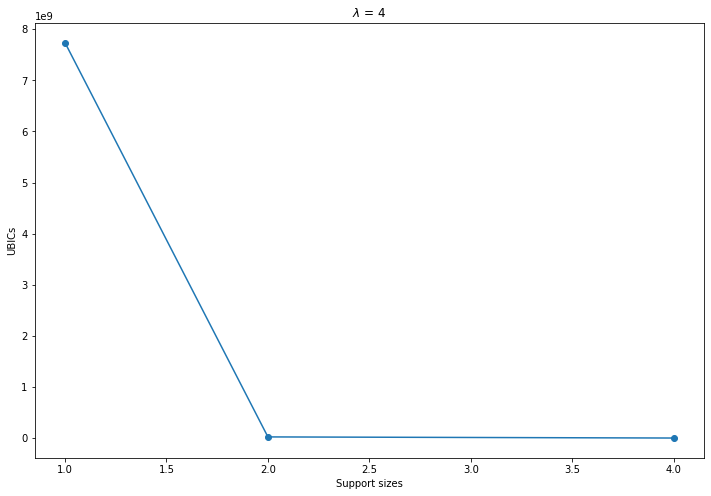

In [14]:
lam = 0; delta = 2
UBICs = BICs+(10**lam)*log(len(v_pre))*uncertainties
bc = []
while True:
    UBICs = BICs+(10**lam)*log(len(v_pre))*uncertainties
    print(np.argmin(UBICs)+1)
    bc.append(np.argmin(UBICs)+1)
    bcl = bc[-3:]
    if len(bc) > 2 and (bcl[0] == bcl[1] == bcl[2]):
        bc = bcl[0]
        break
    lam += delta
    
lam -= 2*delta
print("Optimal complexity =", bc)
UBICs = BICs+(10**lam)*log(len(v_pre))*uncertainties
xaxis = increasing_values_indices(UBICs)+1
yaxis = (UBICs-min(UBICs))[increasing_values_indices(UBICs)]
plt.plot(xaxis, yaxis, '-o')
plt.ylabel("UBICs")
plt.xlabel("Support sizes")
plt.title(f"$\lambda$ = {lam}")
plt.show()

In [15]:
# 
# for effective_indices in brute_solve[-1]:
#     effective_indices = [map2pysindy[ei] for ei in effective_indices]
#     print(effective_indices)

best_subsets = [[map2pysindy[ei] for ei in effective_indices] 
                for effective_indices in brute_solve[-1]]
best_subsets

[[5],
 [35, 71],
 [6, 35, 71],
 [2, 5, 10, 16],
 [2, 5, 10, 16, 40],
 [2, 5, 10, 16, 40, 76],
 [0, 2, 5, 10, 16, 40, 76],
 [2, 5, 10, 16, 40, 71, 72, 76],
 [0, 2, 5, 10, 16, 40, 71, 72, 76],
 [0, 2, 5, 10, 16, 35, 40, 71, 72, 76]]

10
10
10
Optimal complexity = 10


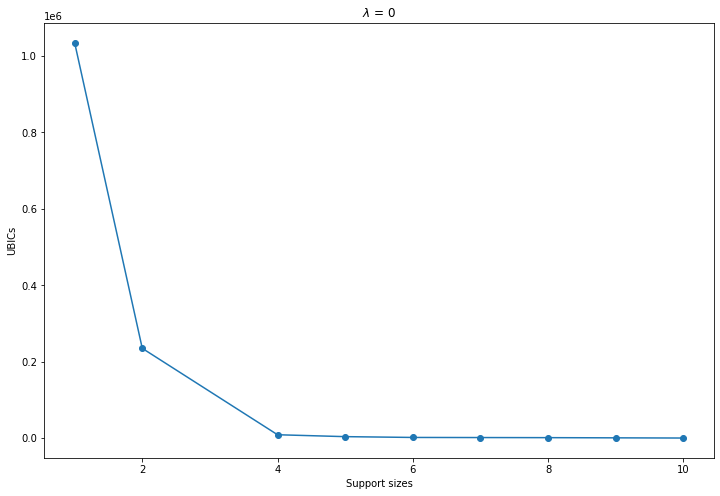

In [16]:
lam = 0; delta = 1
UBICs = BICs+(10**lam)*log(len(v_pre))*uncertainties
bc = []
while True:
    UBICs = BICs+(10**lam)*log(len(v_pre))*uncertainties
    print(np.argmin(UBICs)+1)
    bc.append(np.argmin(UBICs)+1)
    bcl = bc[-3:]
    if len(bc) > 2 and (bcl[0] == bcl[1] == bcl[2]):
        bc = bcl[0]
        break
    lam += delta
    
lam -= 2*delta
print("Optimal complexity =", bc)
UBICs = BICs+(10**lam)*log(len(v_pre))*uncertainties
xaxis = increasing_values_indices(UBICs)+1
yaxis = (UBICs-min(UBICs))[increasing_values_indices(UBICs)]
plt.plot(xaxis, yaxis, '-o')
plt.ylabel("UBICs")
plt.xlabel("Support sizes")
plt.title(f"$\lambda$ = {lam}")
plt.show()

In [17]:
from UBIC import UBIC, UBICs, baye_uncertainties, log_like_value

In [18]:
n_lams = 3
ics, bc, lam = UBICs(best_subsets, 
                     (X_pre, v_pre), 
                     u_type='cv', take_sqrt=True, use_baye=True, 
                     delta=1+1/3, n_lams=n_lams)
ics[-n_lams], bc, lam

n_lams = 3
Using baye_uncertainties
[3.52631655e+04 1.30177977e+04 3.99338652e+04 1.00000000e+00
 1.09459066e+00 1.17971705e+00 1.29326876e+00 1.51919694e+00
 1.64622012e+00 1.75191812e+00]
0 ---> 10
1.3333333333333333 ---> 10
2.6666666666666665 ---> 6
4.0 ---> 4
5.333333333333333 ---> 4
6.666666666666666 ---> 4
[ 3.24765522e+09  1.19875225e+09  3.67780401e+09 -3.63154681e+05
 -3.59421368e+05 -3.53680563e+05 -3.43494348e+05 -3.22945711e+05
 -3.11740976e+05 -3.02521699e+05]
The optimal complexity is currently at the support sizes of 4.


(array([ 3.24765522e+09,  1.19875225e+09,  3.67780401e+09, -3.63154681e+05,
        -3.59421368e+05, -3.53680563e+05, -3.43494348e+05, -3.22945711e+05,
        -3.11740976e+05, -3.02521699e+05]),
 3,
 4.0)

In [19]:
_, _, b_uns = baye_uncertainties(best_subsets, (X_pre, v_pre), u_type='cv', take_sqrt=True)
lower_bounds = []
for efi in best_subsets:
    com = len(efi)
    w = np.linalg.lstsq(X_pre[:, efi], v_pre, rcond=None)[0]
    pred = X_pre[:, efi]@w
    lower_bound = log_like_value(pred, v_pre)/np.log(len(v_pre))-com
    lower_bounds.append(lower_bound)
max_lam = max(np.log10(lower_bounds/b_uns))
delta = np.linspace(0, max_lam, 4)[1]
max_lam

4.392916845041234

In [20]:
n_lams = 3
ics, bc, lam = UBICs(best_subsets, 
                     (X_pre, v_pre), 
                     u_type='cv', take_sqrt=True, use_baye=True, 
                     max_lam=max_lam, 
                     delta=delta, 
                     n_lams=n_lams)

n_lams = 3
Using baye_uncertainties
[3.52631655e+04 1.30177977e+04 3.99338652e+04 1.00000000e+00
 1.09459066e+00 1.17971705e+00 1.29326876e+00 1.51919694e+00
 1.64622012e+00 1.75191812e+00]
0 ---> 10
1.4643056150137446 ---> 10
2.928611230027489 ---> 6
4.392916845041234 ---> 4
[ 8.02606868e+09  2.96275780e+09  9.08913099e+09 -2.27647463e+05
 -2.11096433e+05 -1.93820387e+05 -1.68247096e+05 -1.17083560e+05
 -8.86662668e+04 -6.51241488e+04]
The optimal complexity is currently at the support sizes of 4.


In [21]:
lam

4.392916845041234

In [22]:
tau = 3
thres = 0.02

post_means, b_bics, b_uns = baye_uncertainties(best_subsets, (X_pre, v_pre), u_type='cv1', take_sqrt=True)
predictions = X_pre@post_means
lower_bounds = []
for k, efi in enumerate(best_subsets):
    com = len(efi)
    lower_bound = 2*log_like_value(predictions[:, k:k+1], v_pre)/np.log(len(v_pre))-com
    lower_bounds.append(lower_bound)
    
last_lam = np.log10(max(lower_bounds/b_uns))
delta = last_lam/tau
now_lam = last_lam-delta
last_ubic = UBIC(b_bics, b_uns, len(v_pre), hyp=10**last_lam)
last_bc = np.argmin(last_ubic)
while now_lam > 0:
    now_ubic = UBIC(b_bics, b_uns, len(v_pre), hyp=10**now_lam)
    now_bc = np.argmin(now_ubic)
    
    diff_com = now_bc-last_bc
    imp = abs((b_bics[now_bc]-b_bics[last_bc])/(b_bics[last_bc]*diff_com))
    print(min(last_bc, now_bc), '<--->', max(last_bc, now_bc), np.nan_to_num(imp, nan=np.inf))
    
    if (diff_com > 0 and imp < thres) or (diff_com < 0 and imp > thres):
        break
    
    last_lam = now_lam
    now_lam = last_lam-delta
    last_ubic = now_ubic
    last_bc = now_bc

best_bc = last_bc
if abs((b_bics[last_bc]-b_bics[last_bc-1])/b_bics[last_bc-1]) < thres:
    best_bc = best_bc - 1
    
last_lam = round(last_lam, 10)
last_lam, last_ubic, last_bc, best_bc

3 <---> 5 0.00777409014531394


(4.693981987,
 array([1.60536388e+10, 5.92622641e+09, 1.81799741e+10, 5.89061528e-08,
        3.80843538e+04, 7.47392071e+04, 1.26162256e+05, 2.28757770e+05,
        2.86091568e+05, 3.33695567e+05]),
 3,
 3)

3


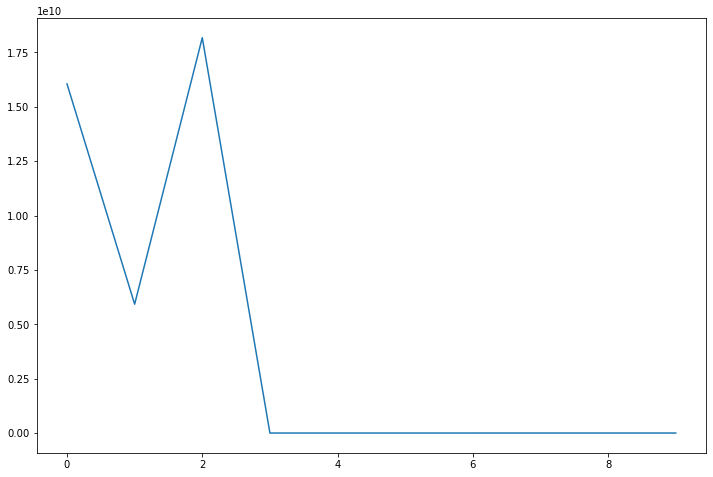

In [23]:
print(np.argmin(last_ubic))
plt.plot(last_ubic); plt.show()